In [ ]:
!pip install diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 23.3 MB/s eta 0:00:00


# Importing Required Libaries

In [ ]:
import torch, logging

## disable warnings
logging.disable(logging.WARNING)

## Imaging  library
from PIL import Image
from torchvision import transforms as tfms

## Basic libraries
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import shutil
import os

## For video display
from IPython.display import HTML
from base64 import b64encode


## Import the CLIP artifacts
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from IPython.display import display, clear_output
import os



### Setting CPU/GPU device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
## Helper functions
def load_image(p):
    '''
    Function to load images from a defined path
    '''
    return Image.open(p).convert('RGB').resize((512,512))



In [ ]:
def pil_to_latents(image):
    '''
    Function to convert image to latents
    '''
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    init_image = init_image.to(device="cuda", dtype=torch.float16)
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215
    return init_latent_dist



In [ ]:
def latents_to_pil(latents):
    '''
    Function to convert latents to images
    '''
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images



In [ ]:

def text_enc(prompts, maxlen=None):
    '''
    A function to take a texual promt and convert it into embeddings
    '''
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to("cuda"))[0].half()




In [ ]:
import torch
from PIL import Image
import io

def prompt_2_img(prompts, g=7.5, seed=100, steps=70, dim=512, save_int=True):
    """
    Diffusion process to convert prompt to image, modified to yield images for Streamlit.
    """

    bs = len(prompts)
    text = text_enc(prompts)
    uncond = text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])

    if seed:
        torch.manual_seed(seed)

    latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))
    scheduler.set_timesteps(steps)
    latents = latents.to("cuda").half() * scheduler.init_noise_sigma

    for i, ts in enumerate(scheduler.timesteps):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad():
            u, t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
        pred = u + g*(t-u)
        latents = scheduler.step(pred, ts, latents).prev_sample

        if save_int and i % (steps // 10) == 0:  # Yield 10 images throughout the process
            image = latents_to_pil(latents)[0]
            buf = io.BytesIO()
            image.save(buf, format="JPEG")
            byte_im = buf.getvalue()
            yield byte_im  # Yield image in bytes format for Streamlit to display

    final_image = latents_to_pil(latents)
    final_buf = io.BytesIO()
    final_image[0].save(final_buf, format="JPEG")
    final_byte_im = final_buf.getvalue()
    yield final_byte_im  # Yield the final image

# Replace `display(latents_to_pil(latents)[0])` with `yield byte_im`


# Overview — The Diffusion Process

- The stable diffusion model takes the textual input and a seed.
- The textual input is then passed through the CLIP model to generate textual embedding of size 77x768 and the seed is used to generate Gaussian noise of size 4x64x64 which becomes the first latent image representation.
- Next, the U-Net iteratively denoises the random latent image representations while conditioning on the text embeddings.
- The output of the U-Net is predicted noise residual, which is then used to compute conditioned latents via a scheduler algorithm.
- This process of denoising and text conditioning is repeated N times (We will use 50) to retrieve a better latent image representation.
- Once this process is complete, the latent image representation (4x64x64) is decoded by the VAE decoder to retrieve the final output image (3x512x512).



In [ ]:

# Initiating tokenizer and encoder.
tokenizer = CLIPTokenizer.from_pretrained("saiabhishek-itta/fine-tuned-clip", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("saiabhishek-itta/fine-tuned-clip", torch_dtype=torch.float16).to("cuda")

#model_id = "CompVis/stable-diffusion-v1-4"
#text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
#tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")

## Initiating the VAE
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to("cuda")

## Initializing a scheduler and Setting number of sampling steps
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
scheduler.set_timesteps(50)

## Initializing the U-Net model
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/717 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [ ]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to("cuda")

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

<ipython-input-8-71e1844bc96c>:18: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))


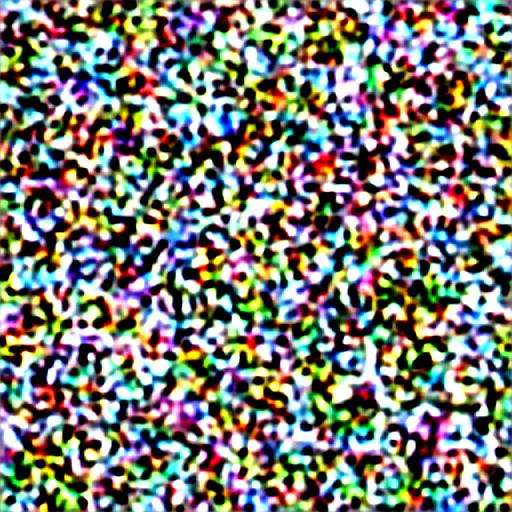

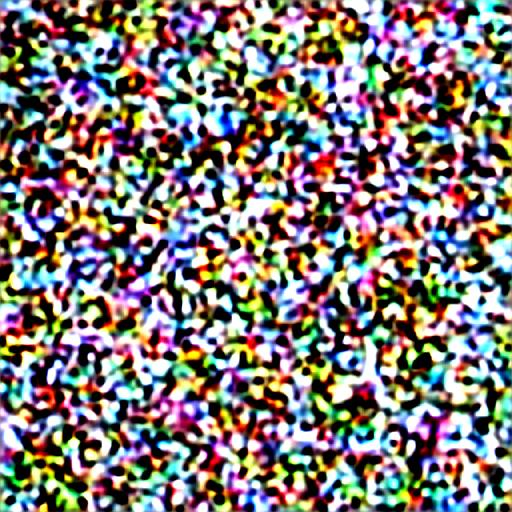

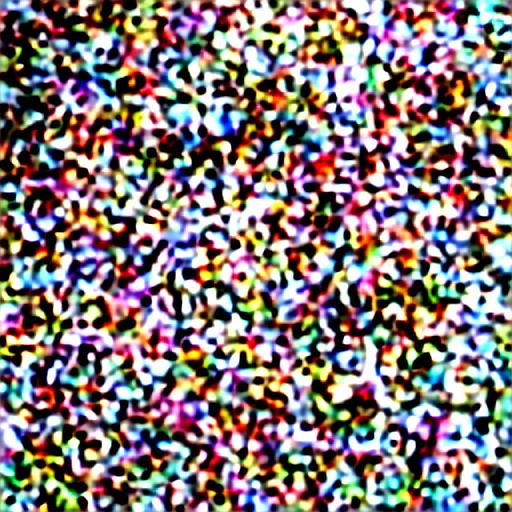

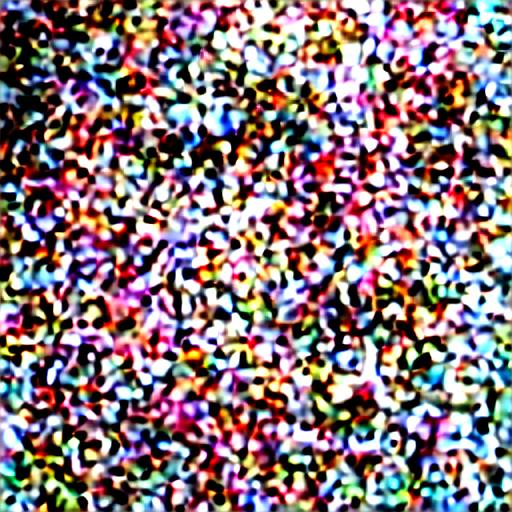

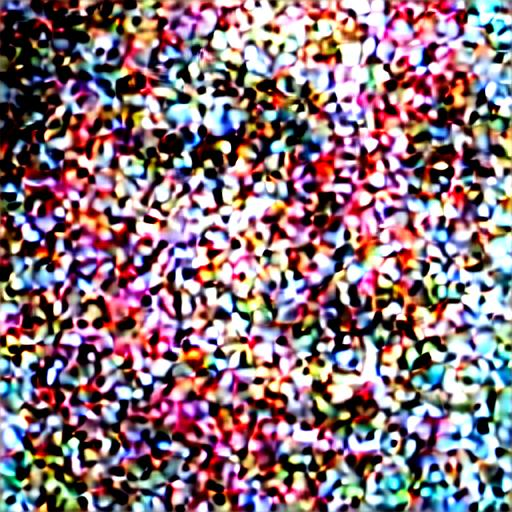

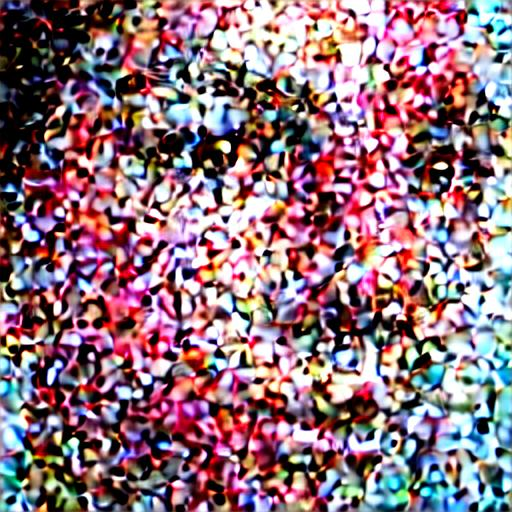

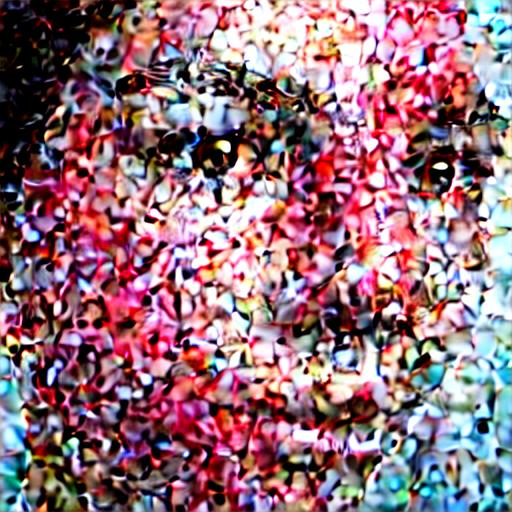

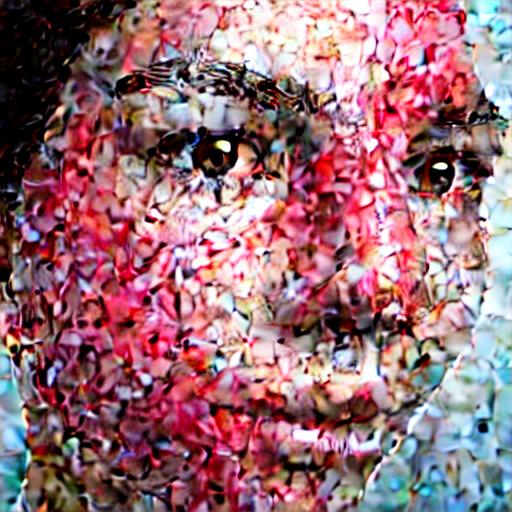

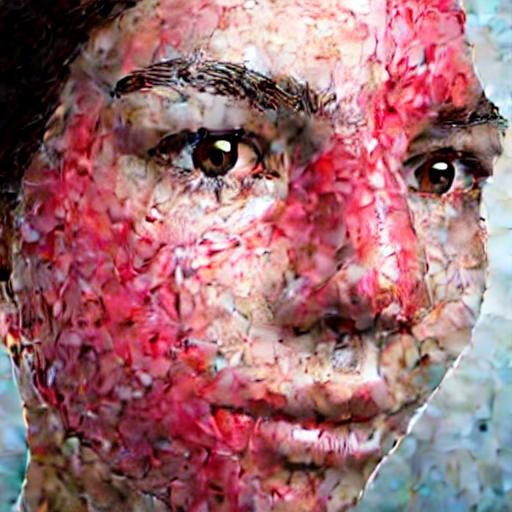

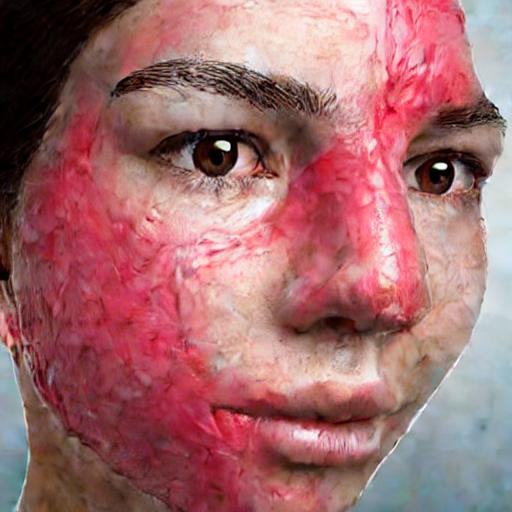

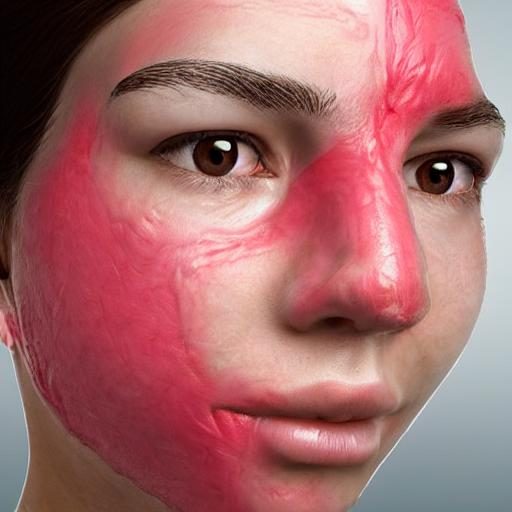

In [ ]:
import io
from PIL import Image
from IPython.display import display  # For Jupyter/IPython environments

# Function to convert byte data to PIL Image
def byte_to_image(byte_data):
    image = Image.open(io.BytesIO(byte_data))
    return image

# Generate images (assuming prompt_2_img returns byte data)
#byte_images = prompt_2_img(["Create a highly detailed and realistic image showing the neck of a person with fair skin. The neck should display a typical ringworm infection, characterized by a clearly visible, circular red rash with a slightly raised, scaly border and healthy-looking skin in the center. The person's hair and other features are not in focus, ensuring the emphasis remains on the neck and the detailed depiction of the skin condition"], save_int=True)
byte_images = prompt_2_img(["Create a highly detailed and realistic image showing face of a person with fair skin. The face should display a dermatitis infection in red colour."], save_int=True)


# Convert byte data to PIL Image and display
for byte_data in byte_images:
    img = byte_to_image(byte_data)
    display(img)